In [1]:
# autoreload
%load_ext autoreload
%autoreload 2

# configure logging
import logging
logging.basicConfig(level=logging.WARNING)
logging.getLogger('Assignment1MicroarrayEpigeneticClock').setLevel(logging.DEBUG)
logging.getLogger('GlmNetEpigeneticClockTrainer').setLevel(logging.DEBUG)
logging.getLogger('download_file').setLevel(logging.DEBUG)

In [2]:
%%time
import os
from epigenetic_clock_assignment import download_file, download_nextcloud_file

data_dir = 'data/assignment1'
meta_filepath = os.path.join(data_dir, 'GSE40279_family.soft-MetaData.csv')
features_filepath = os.path.join(data_dir, 'GSE40279_average_beta.txt')
features_gz_filepath = os.path.join(data_dir, 'GSE40279_average_beta.txt.gz')

# download meta file if does not exists
download_nextcloud_file(folder_url='https://nc.elte.hu/s/9E36fFCnWML33yN',
                       filename='GSE40279_family.soft-MetaData.csv',
                       out_filepath=meta_filepath,
                       password='GSE40279')

# download features file if does not exists
download_file(url='https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE40279&format=file&file=GSE40279%5Faverage%5Fbeta%2Etxt%2Egz',
              out_filepath=features_filepath,
              intermediate_archive_filepath=features_gz_filepath,
              archive_format='gzip')


DEBUG:download_file:file data/assignment1/GSE40279_average_beta.txt does not exists; need to download
DEBUG:download_file:creating directory "data/assignment1" if does not exists...
DEBUG:download_file:downloading...


 99% [................................................................... ] 1221795840 / 1223258643

DEBUG:download_file:ungzipping data/assignment1/GSE40279_average_beta.txt.gz...


100% [....................................................................] 1223258643 / 1223258643

DEBUG:download_file:file data/assignment1/GSE40279_average_beta.txt ready


CPU times: user 15.2 s, sys: 6.17 s, total: 21.4 s
Wall time: 1min 11s


In [3]:
%%time

import os
from epigenetic_clock_assignment import Assignment1MicroarrayDataSource

data_source = Assignment1MicroarrayDataSource(
        meta_filepath=meta_filepath,
        features_filepath=features_filepath
)

X, y = data_source.load()


CPU times: user 13.3 s, sys: 968 ms, total: 14.3 s
Wall time: 14.3 s


In [4]:
%%time
from epigenetic_clock_assignment import GlmNetEpigeneticClockTrainer

clock_trainer = GlmNetEpigeneticClockTrainer(
    n_parallel_jobs=2,
    n_cv_fold=3,
    # the weight of standard error used to determine lambda_best, 0 means use lambda_max (see glmnet.ElasticNet)
    std_error_weight_for_lambda_best=0.5,
    seed=42
)

X_train, X_test, y_train, y_test = clock_trainer.train_test_split(X, y, 
                                                                  test_size=0.2)

hyperparameter_result, hyperparameter_stats, best_model = clock_trainer.hyperparameter_optimization(
    X_train=X_train, 
    y_train=y_train, 
    alpha_count=2 + 1)


DEBUG:GlmNetEpigeneticClockTrainer:starting hyperparameter optimization with alpha range [0.  0.5 1. ]
DEBUG:GlmNetEpigeneticClockTrainer:training with alpha 0.0...
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   3 out of   3 | elapsed:   16.4s finished
DEBUG:GlmNetEpigeneticClockTrainer:training with alpha 0.5...


lambda_max 32 633.7470006985235
target_score 0.7340968686027308 0.5 0.04817365805851659 = 0.7100100395734725
self.lambda_best_ [633.7470007]


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   3 out of   3 | elapsed:   13.0s finished
DEBUG:GlmNetEpigeneticClockTrainer:training with alpha 1.0...


lambda_max 37 0.7960231729550125
target_score 0.8810246318521392 0.5 0.0208696346443962 = 0.8705898145299411
self.lambda_best_ [0.87363445]


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


lambda_max 35 0.4794063649761707
target_score 0.878817612015471 0.5 0.020543857830698054 = 0.868545683100122
self.lambda_best_ [0.47940636]
CPU times: user 1min 44s, sys: 34.5 s, total: 2min 19s
Wall time: 1min 9s


[Parallel(n_jobs=2)]: Done   3 out of   3 | elapsed:   13.0s finished


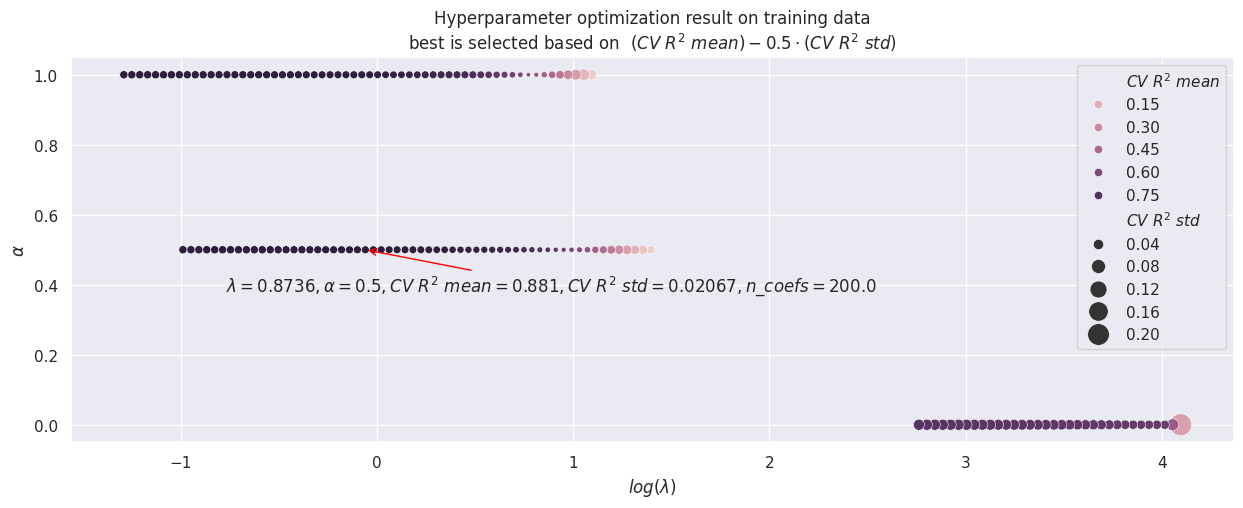

In [5]:
clock_trainer.plot_hyperparameter_optimization_result(hyperparameter_result=hyperparameter_result, hyperparameter_stats=hyperparameter_stats, arrow_xytext_offset=(-100, -30))

# Predict on test data using the best model

In [6]:
best_lambda = hyperparameter_result.lambd
best_alpha = hyperparameter_result.alpha

# sanity check
assert best_model.alpha == best_alpha
assert best_model.lambda_best_ == best_lambda

# predict
y_pred = best_model.predict(X = X_test, lamb=best_lambda)

# Plot linear regression result

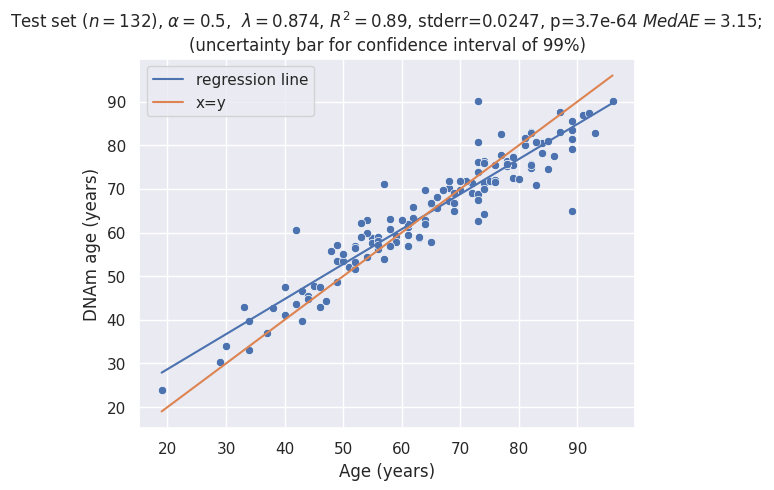

In [7]:
stats = clock_trainer.calculate_statistics(y_true=y_test, y_pred=y_pred)
clock_trainer.plot_linear_regression_result(y_true=y_test, y_pred=y_pred, stats=stats, alpha=best_alpha, lamb=best_lambda)

In [8]:
# TODO: 

# Feature importance based
# Shap Feature Importance
# feature matrix
# glider-nel mint tanitottunk es min teszteltunk
# scatter plot, ahol sok pont van, ott pirosabb (hoterkep)


# delta age  pred - pred age
# delta age az colleral az eletkorral (fiatalokra gyakran lesz pozitiv , oregekre negativ)
# age acc. : prefictalt eletkorbol kivonjuk a regresszios egyenest -> az az erdekes, akik kilognak